## Compute Welfares

In [58]:
# Define the various scenarios
N = 100
experiments = [
    #dict(name='cesds', param='delta', range=(0.2,0.3,N)),
    dict(name='ces', param='xi', range=(0.2,1.0,N)),
    dict(name='exponential', param='alpha', range=(0.1,10,N)),
    dict(name='translog', param='sigma', range=(0.1,10,N)),
    #dict(name='cesds_EL1', param='varphi', range=(0.2,10,N)),
    #dict(name='cesds_EL2', param='mu', range=(1.1,2,N)),
    #dict(name='cesds_EL21', param='varphi', range=(0.2,10,N)),
    #dict(name='cesds_EL22', param='mu', range=(1.1,2,N)),
    #dict(name='cesds_EL31', param='varphi', range=(0.2,10,N)),
    #dict(name='cesds_EL32', param='mu', range=(1.1,2,N)),
    dict(name='cesds_EL42', param='mu', range=(1.1,2,N)),
    dict(name='cesds_EL41', param='varphi', range=(0.2,10,N)),
    dict(name='cesds_EI1', param='zeta', range=(0.3,0.9,N)),
    dict(name='cesds_EI2', param='mu', range=(1.1,2,N)),
    dict(name='translog_ELEI_a', param='sigma', range=(1.2,10,N)),
    dict(name='translog_ELEI_b', param='sigma', range=(1.2,10,N))
    
]

In [59]:
def num_there(s):
    return any(i.isdigit() for i in s)


def compute_case(expm):
    '''Evaluates welfare for the planner and the competitive equilibrium for various values of a specified parameter.
    
    Parameters
    ----------
    expm: dict
        Description of the experiment to perform. Contains several fields:
        - name: name of the experiment, the corresponding model file is expected to be model_*name*.yaml
        - param: name of the parameter to change
        - range: set of parameter values (min value, max value, N values)
    Returns
    -------
    df: pandas.DataFrame
        Each line contains:
        - parameter value
        - welfare for the planner optimum
        - welfare for the competitive equilibrium
    '''
        
    
    import pandas
    from dolo import yaml_import
    from numpy import exp, array, linspace, column_stack
    from dolo.algos.perturbations_higher_order import perturbate
    from dolo.algos.simulations import tabulate
    from dolo.algos.steady_state import residuals
    from dolo.algos.steady_state import find_steady_state
    
    import sympy
    from sympy import  Symbol, solve

    
    case = expm['name']
    param = expm['param']
    range = expm['range']
    
    # create parameter range
    parm_vec = linspace(*range)
        
    # import model and get discount rate
    if num_there(case) == True:
        model = yaml_import('model_{}.yaml'.format(case[:-1]))
    else:    
        model = yaml_import('model_{}.yaml'.format(case))
    beta = model.calibration['beta'];
    
    values_ce = []
    values_po = []
    
    # solve all calibrations
    for i in parm_vec:
        
        # Set calibrated parater value
        pp = {param:i}
        model.set_calibration(**pp)
        
        
        # Solve for the competitive equilibrium
        model.set_calibration(po=0);
        calib = find_steady_state(model);
        res = residuals(model,calib=calib)
        
        
        if abs(sum(res['arbitrage'])) + abs(sum(res['transition'])) > 0.00001:
            print('model', case, 'ME', param, '=', i, '--> steady state cant be found: non-zero residuals')  
        #else:
            #model.calibration['controls'] = calib['controls']
            #model.calibration['states'] = calib['states']  
            
        dr_ce = perturbate(model, order=2, steady_state=calib);

        # Solve for the social planner equilibrium
        model.set_calibration(po=1);
        calib = find_steady_state(model);
        res = residuals(model,calib=calib)
        if abs(sum(res['arbitrage'])) + abs(sum(res['transition'])) > 0.00001:
            print('model', case, 'PO', param, '=', i, '--> steady state cant be found: non-zero residuals')
        #else:
            #model.calibration['controls'] = calib['controls']
            #model.calibration['states'] = calib['states']         
        
        dr_po = perturbate(model, order=2, steady_state=calib);   
        
                    
            
        # Initial point at which to evaluate the welfare
        eval_point = calib['states'].copy();
        # Change initial value of N
        eval_point[1]*=0.5 # to 50 % of its of its steady-state value
        #eval_point[1]= 1    # to 1

        # Evalueate welfare
        w_ce = dr_ce(eval_point)[1]
        w_po = dr_po(eval_point)[1]
        
        # Convert to consumption equivalent
        v_ce = exp((1-beta)*w_ce)
        v_po = exp((1-beta)*w_po)
        
        # Add to list of values
        values_ce.append(v_ce)
        values_po.append(v_po)
    
   
    # Construct dataframe
    columns = [h.format(case) for h in ['{}_'+param, '{}_po', '{}_ce']]
    df = pandas.DataFrame( column_stack([parm_vec, values_po, values_ce]), columns=columns)
    
    return df

In [60]:
# parrallel evaluation (needs 3 workers)
# from IPython.parallel import Client
# rc = Client()
# dviews = rc[:3]
# all_welfares = dviews.map_sync(compute_case, experiments)

In [61]:
# serial evaluation
all_welfares = [compute_case(exp) for exp in experiments]

In [62]:
# Add welfare gains to dataframe
import pandas
df = pandas.concat(all_welfares, axis=1)
# compute gains
for exp in experiments:
    case = exp['name']
    df['{}_gain'.format(case)] = (df['{}_po'.format(case)]/df['{}_ce'.format(case)]-1)*100
# save to Excel
df.to_excel('welfare_gains.xls')
df;

## Make plots

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

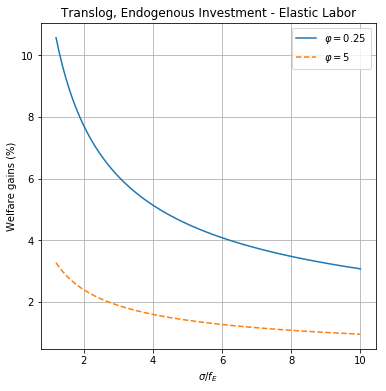

In [80]:
fig = plt.figure(figsize=(6,6))
plt.plot(df['translog_ELEI_a_sigma'],df['translog_ELEI_a_gain'], label="$\\varphi = 0.25$")
plt.plot(df['translog_ELEI_b_sigma'],df['translog_ELEI_b_gain'], label="$\\varphi = 5$", linestyle='--', )
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\sigma/ f_{E}$")
#yl = plt.ylim()
#plt.ylim(0,yl[1])
plt.title("Translog, Endogenous Investment - Elastic Labor")
plt.grid()
plt.legend(loc='best')
# xlim(4,8)
# ylim(0,0.2)


plt.savefig('BGM_welfare_gains_general_model.pdf')

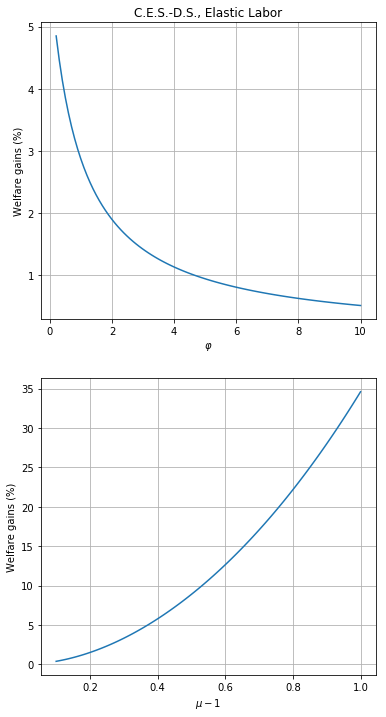

In [79]:
fig = plt.figure(figsize=(6,12))

plt.subplot(211)
plt.plot(df['cesds_EL41_varphi'],df['cesds_EL41_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\varphi$")
#yl = plt.ylim()
#plt.ylim(0,yl[1])
plt.title('C.E.S.-D.S., Elastic Labor')
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.subplot(212)
plt.plot(df['cesds_EL42_mu']-1,df['cesds_EL42_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\mu-1$")
#yl = plt.ylim()
#plt.ylim(0,yl[1])
#plt.title("C.E.S.-DS, Elastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.savefig('BGM_welfare_gains_EL.png')
plt.savefig('BGM_welfare_gains_EL.pdf')
plt.savefig('BGM_welfare_gains_EL.svg')

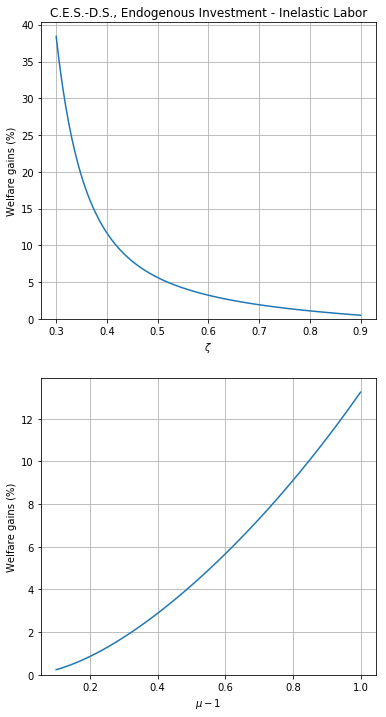

In [78]:
fig = plt.figure(figsize=(6,12))


plt.subplot(211)
plt.plot(df['cesds_EI1_zeta'],df['cesds_EI1_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\zeta$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("C.E.S.-D.S., Endogenous Investment - Inelastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)


plt.subplot(212)
plt.plot(df['cesds_EI2_mu']-1,df['cesds_EI2_gain'])
plt.ylabel('Welfare gains (%)')

plt.xlabel("$\\mu-1$")
yl = plt.ylim()
plt.ylim(0,yl[1])
#plt.title("C.E.S.-DS, Endogenous Investment - Inelastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.savefig('BGM_welfare_gains_EI.png')
plt.savefig('BGM_welfare_gains_EI.pdf')
plt.savefig('BGM_welfare_gains_EI.svg')

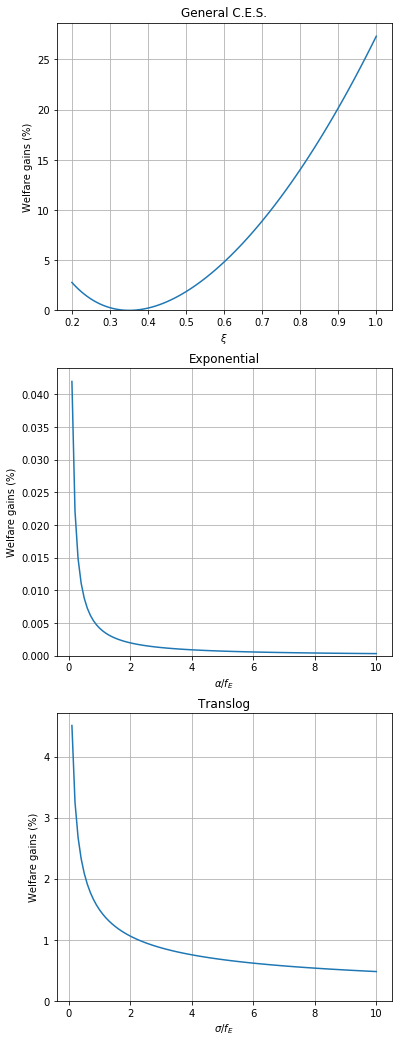

In [77]:
### Baseline model ###
fig = plt.figure(figsize=(6,18))
plt.subplot(311)
plt.plot(df['ces_xi'],df['ces_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\xi$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("General C.E.S.")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(312)
plt.plot(df['exponential_alpha'],df['exponential_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Exponential")
plt.xlabel("$\\alpha/ f_{E}$")
plt.ylabel('Welfare gains (%)')
plt.subplot(313)
plt.plot(df['translog_sigma'],df['translog_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Translog")
plt.xlabel("$\\sigma/ f_{E}$")
plt.ylabel('Welfare gains (%)')
plt.savefig('BGM_welfare_gains.png')
plt.savefig('BGM_welfare_gains.pdf')
plt.savefig('BGM_welfare_gains.svg')
